# ColabMDA

## Installation

1. Install GROMACS and Necessary Dependencies

In [ ]:
# Download and unzip the compressed folder of GROMACS 2020.6 version
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/software/gromacs.tar.gz
!tar xzf gromacs.tar.gz

In [ ]:
# It is recommended (and required for GROMACS 2021) to upgrade cmake
!pip install cmake --upgrade

In [ ]:
# If you get : gmx: error while loading shared libraries: libhwloc.so.5: cannot open shared object file: No such file or directory
!wget https://download.open-mpi.org/release/hwloc/v1.11/hwloc-1.11.13.tar.gz


!tar xzf hwloc-1.11.13.tar.gz
!cd /content/hwloc-1.11.13
! /content/hwloc-1.11.13/configure
!make
!sudo make install



In [ ]:
# Checking that our GROMACS works
%%bash
source /content/gromacs/bin/GMXRC
gmx -h

2. Now, we will install **py3Dmol** as follows:

In [ ]:
#Installing py3Dmol using pip
!pip install py3Dmol

In [ ]:
#Importing py3Dmol for safety
import py3Dmol

3. Finally, we will install **biopython**

In [ ]:
#Installing biopython using pip
!pip install biopython

Once these software installation processes are completed, we are ready to perform our experiments

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Part I – Setting up the MD simulation system

GROningen Machine for Chemical Simulations (**GROMACS**) is an open-source, free software developed by the University of Groningen with consistent and continuous support. It also has been optimized for calculations by maximizing the usage of all available computational resources (GPU and CPU). Once installed, you can access all the modules it has for setting up, running and analyzing MD simulations by just inputting:

**`gmx [module]`**

The list of modules can be displayed when **`[module]=help`**. Try it out here!

In [ ]:
#We will constantly need to source GMXRC for GROMACS to work
%%bash
source /content/gromacs/bin/GMXRC

#Try gmx here!


The initial steps of setting up a system for MD simulations are:

1. **Cleaning up** the input atomic coordinates
2. **Parameterizing** the atoms building up our system
3. **Solvating** our protein (and adding a lipid membrane in the case of membrane proteins)
4. **Adding** counterions to neutralize the global charge of the system

### Part I.1 – Cleaning up the input atomic coordinates

For this step, we first need an initial set of atomic coordinates, usually coming from a protein structure downloaded from the Protein Data Bank. Once download, these PDB files must be cleaned from water molecules (in the case of crystal structures) or a single model must be selected from the many solutions for a single set of chemical shifts (in the case of NMR structures).

1. We will first start by making a folder for preparing our system and running our simulations, as we have done in the past (remember our Molecular Docking tutorial?)

In [ ]:
#Let's make a folder first. We need to import the os and path library
import os
from pathlib import Path 

#Then, we define the path of the folder we want to create.
#Notice that the HOME folder for a hosted runtime in colab is /content/
mdpath = Path("/content/gdrive/MyDrive/works/research/psmb8/psmb8-100/3unf-g210v-100")

#Now, we create the folder using the os.mkdir() command
#The if conditional is just to check whether the folder already exists
#In which case, python returns an error
if os.path.exists(mdpath):
  print("path already exists")
if not os.path.exists(mdpath):
  os.mkdir(mdpath)
  print("path was succesfully created")

path already exists


2. Then, we will change directory to this newly created folder and download the recently X-ray solved structure of the papain-like protease (PLpro) of SARS-CoV-2 (PDB 6WZU).

In [ ]:
#First, we will change to the new folder. We will use python now :)
os.chdir(mdpath)

In [ ]:
#Importing your PDB file using biopython
import os
from Bio.PDB import *
pdbid = ['3unf']
pdbl = PDBList()
for s in pdbid:
  pdbl.retrieve_pdb_file(s, pdir='.', file_format ="pdb", overwrite=True)
  os.rename("pdb"+s+".ent", s+".pdb")

3. This structure has a few residues in two different conformations (remember when we discussed **occupancy** in classes and during our second tutorial?). We can filter out one of them,  

In [ ]:
#Here we set up a parser for our PDB
parser = PDBParser()
io=PDBIO()
structure = parser.get_structure('X', '6wzu.pdb')
#And here we set the residue conformation we want to keep
keepAltID = "A"

class KeepOneConfOnly(Select):  # Inherit methods from Select class
    def accept_atom(self, atom):
        if (not atom.is_disordered()) or atom.get_altloc() == keepAltID:
            atom.set_altloc(" ")  # Eliminate alt location ID before output.
            return True
        else:  # Alt location was not one to be output.
            return False
        # end of accept_atom()

#This will keep only conformation for each residue
io.set_structure(structure)
io.save("6wzu_ready.pdb", select=KeepOneConfOnly())
print("Your PDB was processed. Alternative side chain conformations removed!")

4. Commonly, crystallographic waters and other solvent molecules are stripped from the experimentally solved structure before preparing the MD system. This is also useful for removing hydrogens, which are often found in NMR structures, as they are a nightmare to pass through the atomic conventions of a given force field. We can do this using `Dice` from **biopython** as show in the code cell bellow.

❗️**NOTE:** This procedure is not universally appropriate. Some water molecules could be essential for the function of a protein and thus maintained in the simulation. Also, `Dice` removes ligands, which in some cases need to be maintained depending on the goal of your simulations and the ability to parameterize your ligands. Sometimes, it will be more useful to use `grep`. For example:

  `!grep -v "HOH" 6WZU_ready.pdb > 6WZU_clean.pdb`
  
  This grep command would remove only water molecules from the PDB file.

In [ ]:
#Here we set up a parser for our PDB
parser = PDBParser()
io=PDBIO()
structure = parser.get_structure('X', '6wzu_ready.pdb')
#And here we remove hydrogens, waters and ligands using Dice
io.set_structure(structure)
sel = Dice.ChainSelector('A', 1, 5000)
io.save("6wzu_clean.pdb", sel)
print("Your PDB was processed. Only the protein heavy atoms have been kept!")

5. Let's load the protein that we are working with using py3dmol

In [ ]:
#First we assign the py3Dmol.view as view
view=py3Dmol.view()
#The following lines are used to add the addModel class
#to read the PDB files
view.addModel(open('6wzu_clean.pdb', 'r').read(),'pdb')
#Here we set the background color as white
view.setBackgroundColor('white')
#Here we set the visualization style and color
view.setStyle({'chain':'A'},{'cartoon': {'color':'spectrum'}})
#Centering view on all visible atoms
view.zoomTo()
#And we finally visualize the structures using the command below
view.show()

### Part I.2 – Parameterizing the atoms building up our system

Now, we will work with GROMACS to parameterize our protein, generating:

*   A **.gro** or **.pdb** coordinate file that contains all the atom types as defined by a given force field (including hydrogens).
*   A **.top** topology file containing the parameters for bonds, angles, dihedrals and non-bonded interactions defined by a given force field (potential energy function) to employ in our simulations.

1. We will parameterize our protein using the **AMBER99SB-ILDN force field** on GROMACS and obtain these files using `gmx` as shown in the code cell below. This force field is extensively used in MD simulations and has parameters that well-represent the dynamics and flexibility of folded proteins. Notice that the dynamics of highly motile proteins or intrinsically disordered regions is not the main dataset for which this force field was parameterized, and other options may better suit such goals.

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#Using pdb2gmx to parameterize our PDB with the AMBER forcefield and SPC/E water
gmx pdb2gmx -f 6wzu_clean.pdb -o 6wzu_processed.pdb -water spce -ignh -ff amber99sb-ildn

When using this command, the `-f` option corresponds to the input file, the `-ff` option allows to define the force field to be used and the `-o` option provides the output name for the .coordinate file. The topology file receives a default `topol.top` name, although this can be altered with the `-p` option. 

We are also indicating the type of water molecule that we will be using in our simulations through the `-water` option. Yes, there are many water models, but their features are outside the scope of our tutorial. Our selected water model is SPC/E (simple point charge - extended), which models water molecules as a 3-point molecule, each with its own charge. TIP3P is a more common water model, similar to SPC/E but with slightly different parameters. The accuracy of the model used changes depending on the calculations that you will perform, as their dynamic and energetics will differ.

❗️**NOTE:** When working with NMR files, it is useful to incorporate the `-ignh` option, that allows to ignore hydrogens contained in the PDB file. During parameterization, hydrogens are always added back by the force field, as it contains the typical distance parameters for all atoms based on experimental/quantum mechanics analysis.

### Part I.3 – Solvating our protein

We will now define a periodic box for our simulation system, in which our protein will be centered ,and then fill this box with water molecules, thus solvating our protein.

Given the use of **periodic boundary conditions** and the computational costs of the evaluation of non-bonded interactions, it is imperative to properly define the distance of the periodic box such that it is large enough to avoid interactions between our molecule and its periodic images, while at the same time minimizing the number of water molecules (in essence, the number of non-bonded interactions to evaluate during the simulation).

It is often recommended for globular proteins to have a **padding distance** between the furthest protein atom from the center of the periodic box and its edges of 1.0-1.5 nm. If your system has one dimension much larger than the others (i.e. fibrillar proteins) you may wish to draw this periodic box more carefully. 

1. First, we will generate a periodic box using `editconf` as follows:

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#Using editconf to create a cubic box with 1.0 nm padding for our solvated system
gmx editconf -f 6wzu_processed.pdb -o 6wzu_newbox.pdb -c -d 1.0 -bt cubic

The options provided to `editconf` enable to center (`-c`) the atom coordinates of our protein (`-f`) in a cubic box (`-bt cubic`) with a padding distance of 1.0 nm from the box edge (`-d 1.0`).

Given periodic boundary conditions, this means that the system will be at the closest 2.0 nm from itself, in which most of the non-bonded terms are out of range between periodic images due to the use of distance cut-offs. Thus, the only molecules that will be interacting between the edges of the periodic box are water molecules and ions. These new coordinates and simulation box are saved in a new coordinate file (`-o`).

2. Once the periodic box is defined, we proceed to fill this box with water molecules using `solvate`. To do this, we execute:

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#Using solvate to fill up our box with water molecules
gmx solvate -cp 6wzu_newbox.pdb -o 6wzu_solv.pdb -p topol.top

Please note that, given the addition of water molecules to our simulation system, we are generating **a new topology file** (`-p` option) and **a new coordinate file with added water molecules** (`-o` option).

Whenever we write a new topology file (or any file with the same name), GROMACS backups the previous file by adding a `#` symbol (i.e. `#topol.top.1`) and then generates the new .top file. This way you do not have to worry about backing up the files.

**QUESTION❓:** From reading the output of the previous command, how many water molecules were added? 

3. Let's look at the solvated system using py3Dmol! How are the water molecules solvating the protein? Are the molecules homogeneously distributed?

In [ ]:
#First we assign the py3Dmol.view as view
view=py3Dmol.view()
#The following lines are used to add the addModel class
#to read the PDB files
view.addModel(open('6wzu_solv.pdb', 'r').read(),'pdb')
#Here we set the background color as white
view.setBackgroundColor('white')
#Here we set the visualization style and color
view.setStyle({'cartoon': {'color':'green'}})
#Here we add a style for showing the oxygen from water molecules
view.addStyle({'atom':'OW'},{'sphere':{'radius':'0.2'}})
#Centering the view on all visible atoms
view.zoomTo()
#And we finally visualize the structures using the command below
view.show()

## Part I.4 – Adding counterions to neutralize the global charge of the system

Now we have a solvated box, but our system has a **non-zero charge**. This is an issue, as each periodic box will have a formal charge, which would cause electrostatic potentials to become unrealistically high among periodic images. Thus, we need to neutralize the charges of our simulation system.

1. Let's easily determine the absolute charge in our system by using `grep`

In [ ]:
!grep "qtot" topol.top

**QUESTION❓:** What is the total charge of our system?

To neutralize the simulation system, we will replace water molecules with the counterions required to get the absolute charge of the system to **zero**. While this might be sufficient for globular proteins in water, in some cases you might find more useful to reach a particular salt concentration or generate charge differences, for example in the case of simulations of ion channels in a lipid bilayer.

2. The addition of counterions is achieved by building a **portable binary run input file for GROMACS**, or **.tpr file**. This file contains the information from the coordinates, topology/parameters and an **MD instruction file** (**.mdp**). This instruction file contains all the parameters that will be used for running different calculations, and you can input flags that will be read by those specific programs.

  We will download and use a predefined **ions.mdp** file (**please take a look at it!**) onto our simulation folder and generate the .tpr run input file by executing the following command with the `grompp` module:

In [ ]:
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/ions.mdp

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#Using grompp and an MD instruction file to add counterions to our system
gmx grompp -f ions.mdp -c 6wzu_solv.pdb -p topol.top -o ions.tpr

Please note that, in the case of `grompp`, the `-f` option is now used for the .mdp file, while `-c` is used for the coordinates.

3. Once this is done, run the `genion` module for randomly replacing water molecules in your simulation system with an appropriate number and type of counterions.

❗️**NOTE:** Usually `gmx` would **interactively request us** to choose a group for this replacement (in our case, group 13 "SOL", corresponding to water molecules). Here, we are solving the impediment of doing this on Google Colab by **generating a text file with these options**, which then we pass onto `gmx` to be read

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "SOL" > options
echo " " >> options

#Using genion and the tpr to add counterions to our solvated system
gmx genion -s ions.tpr -o 6wzu_solv_ions.pdb -p topol.top -pname NA -nname CL -neutral < options

**QUESTION❓:** What type of monovalent ion was added? How many ions were added?

We have finalized preparing the simulation system with our protein in the center of a cubic box with 1.0 nm of padding, solvated in water molecules and neutralized with counterions. You can choose to visualize it using py3Dmol if you want!

#Part II – Minimizing and Equilibrating the MD system

Now, we are ready to perform the minimization of our system to eliminate the high energy and forces due to bad initial coordinates, and its equilibration at constant pressure and temperature (NPT ensemble).

1. We will start by downloading an MD instruction file that contains all of the parameters required for the minimization of our system. We will also print its contents for inspection.

In [ ]:
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/em.mdp


In [ ]:
#Check the content of the MDP file
!paste em.mdp

As you can see, the minimization process involves the use of a **steepest descent** (`steep`) integrator. This integrator, alongside conjugate gradient (`cg`) and a quasi-Newtonian method (`l-bfgs`), are **minimization algorithms** that instead of solving the positions for changes in the gradient (Newton’s equation of motion), look for changes in position that would **minimize the potential energy**.

These minimization (sometimes referred to relaxation) protocols make sure that the **starting point from our simulations has a ΔU favorable enough** for Verlet and leapfrog algorithms (which enable the **propagation of changes in atom positions for each time step**) to be numerically integrable.

In simpler words, this step is critical as starting from a high potential energy can generate from highly divergent simulations, in the mildest of cases, to energetic instabilities that would make our system impossible to numerically integrate (typically known as a **“system that explodes”**).


2. We will pre-process our files with `grompp` and then run our MD with `mdrun`. Check the resemblance (and also differences) of the use of `grompp` for adding neutralizing counterions and the system minimization.

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#Using grompp to prepare our minimization MD
gmx grompp -f em.mdp -c 6wzu_solv_ions.pdb -p topol.top -o em.tpr

#Run our minimization
gmx mdrun -v -deffnm em -nb gpu

For `mdrun`, we are using the verbose option (`-v`) to output the changes in forces between atoms during the system minimization. As the system is minimized, these forces should be reduced when compared to the initial system.

The `-deffnm` option simply states that all MD-generated files will have the same standard name (in this case, *em*) as the .tpr file generated with `grompp`

**📚HOMEWORK:** Look up which files have been generated after `mdrun`. What is inside each generated file? If you do not know, **Google it!** This step is **obligatory**.

😱 **EMERGENCY BACKUP!** Ran out of time and could not minimize your system? Use the following code cell to download a readily minimized system:

In [ ]:
#Use only in case of emergency
#!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/emergency_backup/lab07/6wzu_em.tar.gz
#!tar xzf 6wzu_em.tar.gz

3. Once our minimization is finished, we can check how the potential energy of the system changes over each minimization step. For this, we will use the `energy` module to extract the potential energy, and then we will plot it using **matplotlib**:

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Potential" > options
echo " " >> options

#Using energy to extract the potential energy of the system
gmx energy -f em.edr -o em_potential.xvg -xvg none < options

In [ ]:
#Plotting the potential energy of the system
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('em_potential.xvg')

plt.title('Potential Energy during Minimization')
plt.xlabel('Energy Minimization Step')
plt.ylabel(r'E$_P$ [kJ•mol$^{-1}]$')
plt.plot(data[:,0], data[:,1], linestyle='solid', linewidth='2', color='red') 
plt.show()

Next, we will start our **equilibration**. This step is required given that we optimized the positions of the atoms according to our force field, but at no point we maximized the interactions between solvent and solute. We also have not established the **kinetic effect of temperature on atom motions** or the **pressure of our system**, thus making it unrelatable to experimental conditions.

Thus, we will **equilibrate the energy and density of our system at constant temperature and pressure** before the MD production runs.

4. The first equilibration step is the **temperature**. Thus, we will start a MD simulation to equilibrate the system at a target temprature (in our case, 300K) using a thermal bath. The initial velocities for the atoms of our system at our target temperatureare obtained through a Maxwell distribution.

  We will first download an appropriate MD instruction file and then run our simulation as we did before for the minimization. Also note that we are now using **GPU resources** for the non-bonded interactions.

In [ ]:
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/nvt.mdp

In [ ]:
%%bash

#Using grompp to prepare our NVT equilibration MD
source /content/gromacs/bin/GMXRC
gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr

In [ ]:
%%time
%%bash
#Run our NVT equilibration MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm nvt -nb gpu

😱 **EMERGENCY BACKUP!** Ran out of time and could not perform the NVT equilibration of your system? Use the following code cell to download a temperature-equilibrated system:

In [ ]:
#Use only in case of emergency
#!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/emergency_backup/lab07/6wzu_nvt.tar.gz
#!tar xzf 6wzu_nvt.tar.gz

If you take a look at the MD instruction file for this step, you will notice that we are now using a **leapfrog algorithm** (`md`) for propagation of the protein motions upon time.

 Among several parameters, we can read that the **hydrogen atoms are constrained**. This is because those nuclei have little mass and are commonly inside the Lennard-Jones radius of a molecule, lack any type of dihedral motions, and the distance of the bond is highly conserved. This is why constraint algorithms are used to simplify their movement equations, while keeping the effect they have on solvation and interactions. Given that the faster internal motions correspond to the bond vibrations between light atoms (such as hydrogen), their constraining enables the use of **higher timesteps** (in our case, we will use **2 fs**).

Finally, in this equilibration step a **position restraining algorithm** is used to keep the heavy atoms of our protein in place. This is because we know our protein structure is mostly ideal (because it is modeled from experimental data), but our solvent molecules were just drawn around it. So, in this step we will keep our protein mostly in place and let the solvent rearrange around our protein as we would expect it to do at 300 K. This information is in the **posre.itp** (a position restrain file) that was generated at the beginning of the use of GROMACS. This restrain is performed via the `-r em.gro` option.


5. What we just did corresponds to a simulation setup in which the number of atoms, the volume and the temperature are kept constant: **NVT ensemble**. Thus, the temperature of the system should oscillate around the desired temperature (in our case, 300 K). Let's check if this is true!

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Temperature" > options
echo " " >> options

#Using energy to extract the temperature of the system during the NVT equil MD
gmx energy -f nvt.edr -o nvt_temp.xvg -xvg none < options

In [ ]:
#Plotting the temperature of the system
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('nvt_temp.xvg')

plt.title('Temperature during 1000 ps Equilibration (NVT)')
plt.xlabel('Time (ps)')
plt.ylabel('Temperature [K]')
plt.plot(data[:,0], data[:,1], linestyle='solid', linewidth='2', color='red') 
plt.show()

6. The final equilibration step will allow us to implement **pressure regulation** to our system, which will maintain the density and pressure of our solvent constant so that it matches what we would expect for the SPC/E water model. Thus, in this case we will be using an ensemble in which the number of atoms, the pressure and the temperature of the system remain constant: **the NPT ensemble**.

  We will perform the same steps we did before: download an MD instruction file, and then use `grompp` and `mdrun` to run the MD simulation. One big difference between this simulation phase and the previous ones is that we will employ a **checkpoint state file** (nvt.cpt), which allows for a numerical continuation of our simulations. This file constitutes a checkpoint of the previous NVT simulation, containing the potential energy of the system and the velocities.

In [ ]:
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/npt.mdp


In [ ]:
%%bash

#Using grompp to prepare our NPT equilibration MD
source /content/gromacs/bin/GMXRC
gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

In [ ]:
%%time
%%bash
#Run our NPT equilibration MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm npt -nb gpu

**⚠️CAUTION:** We used a Parrinello-Rahman barostat instead of Berendsen for the NPT equilibration. This should not be an issue if the system is adequately equilibrated, otherwise the combination of restraints and Parrinello-Rahman would be inappropriate as it could lead to instabilities.

😱 **EMERGENCY BACKUP!** Ran out of time and could not perform the NPT equilibration of your system? Use the following code cell to download a pressure-equilibrated system:

In [ ]:
#Use only in case of emergency
#!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/emergency_backup/lab07/6wzu_npt.tar.gz
#!tar xzf 6wzu_npt.tar.gz

7. Given that we are using an NPT ensemble to maintain our simulation at constant pressure and density, we should check if this is achieved.

In [ ]:
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Pressure" > options
echo "Density" >> options
echo " "

#Using energy to extract the pressure and density of the system during the NPT equil MD
gmx energy -f npt.edr -o npt_press_dens.xvg -xvg none < options

In [ ]:
#Plotting the density of the system
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('npt_press_dens.xvg')

plt.title('Pressure during 1000 ps Equilibration (NPT)')
plt.xlabel('Time (ps)')
plt.ylabel('Pressure [bar]')
plt.ylim(-500,500)

#Smoothing using Savitzky-Golay
from scipy.signal import savgol_filter
yhat = savgol_filter(data[:,1], 21, 5)

#Plot raw data and spline interpolation
plt.plot(data[:,0], data[:,1], linestyle='solid', linewidth='2', color='red')
plt.plot(data[:,0], yhat, linestyle='solid', linewidth='2', color='blue') 
plt.show()

In [ ]:
#Plotting the pressure of the system
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('npt_press_dens.xvg')

plt.title('Density during 1000 ps Equilibration (NPT)')
plt.xlabel('Time (ps)')
plt.ylabel('Density [kg•m$^{-3}$]')
plt.ylim(1000,1025)
plt.plot(data[:,0], data[:,2], linestyle='solid', linewidth='2', color='red') 
plt.show()

**QUESTION❓:** What is the average value of the density along the trajectory? Sounds familiar? 

Once this section is finished, we can move onto production MD simulations.

#Part III – Obtain a production MD run and analyze the results

Now we are ready for running our MD simulations. If we are using a typical NPT ensemble, we can just continue our simulation similar to our second equilibration, but without having any position restraints (without the `-r` option).

1. If you have paid attention to our previous MD runs, you will fully understand what is annotated in the following code cells. Due to time constraints and the size of the system, we are only generating **0.1 ns of production runs**, whilst you will find that simulations in current articles often correspond to hundreds of ns.

In [ ]:
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/md.mdp


In [ ]:
%%bash

#Using grompp to prepare our production MD
source /content/gromacs/bin/GMXRC
gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md_1.tpr

In [ ]:
#Check the content of the production MD file
!paste md.mdp

In [ ]:
%%time
%%bash
#Run our production MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm md_1 -nb gpu

# Part IV - Appending Simulaiton after interruption

In [ ]:
%%time
%%bash
#Append
source /content/gromacs/bin/GMXRC
gmx mdrun -v -cpi md_1.cpt -noappend -deffnm md_1 -gpu_id 0


2. To finalize, we will visualize our simulation. For this, we will use the `trjconv` module to extract only the protein from our system and convert our trajectory into a PDB file.

  Given that our protein may have drifted from the center of the box and reached its edges, we will also take the opportunity to recenter the periodic box on our protein such that its atoms do not stretch through the edges of the periodic boundary conditions using the `-pbc mol` and `-center` options.

In [ ]:
#%%bash
#source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
#echo "Protein" > options
#echo "Protein" >> options
#echo " "

#Using trjconv to extract only the protein atoms from the simulation trajectory
#and also recenter the protein if its atoms crossed the periodic boundaries
#gmx trjconv -s md_1.tpr -f md_1.xtc -o md_1_protPBC.pdb -pbc mol -center < options

3. Now, you can download this new PDB file and load it onto [**NGLviewer**](http://nglviewer.org/ngl/) as a **trajectory** PDB file to visualize the protein motions explored within this short simulation time.

😱 **EMERGENCY BACKUP!** If you did not obtain the production MD trajectory on time, you can download <a href="https://github.com/pb3lab/ibm3202/blob/master/files/emergency_backup/lab07/md_1_protPBC.pdb" target="_blank"/>this 0.2 ns trajectory</a> by clicking with the right button on *View Raw* and selecting to download it as a file.

**And this is the end of the seventh tutorial!** On the next tutorial, we will learn how to perform some analysis of our MD production runs. 

If you want to download your results, you can perform the following commands:

In [ ]:
# os.chdir("/content/")
# !zip -r md.zip $mdpath
# from google.colab import files
# files.download("/content/md.zip")
# os.chdir(mdpath)

**📚HOMEWORK:** Once you got here, you can perform several exercises!

1.	Try to perform the equilibration without minimization of the simulation system (i.e. skip the use of em.mdp and go straight onto equilibration).
2.	Change the timestep from 2 fs to 4 fs or 5 fs, and check what happens with the simulation system in terms of stability. If you get some warnings and no .tpr file is compiled, you can add the `-maxwarn X` option, where `X` is the number of warnings from GROMACS that you will ignore.

With these examples, it will be possible to better understand why defining the proper timestep and adequately minimize and equilibrate the system are important steps in all MD simulations.

3. Run your simulation for a longer time (for example, 1 ns; ~ 1 h on Google Colab).

# Part V - Concatenate all xtc files

In [ ]:
%%time
%%bash
#Concatenation of xtc files
source /content/gromacs/bin/GMXRC
gmx trjcat -f md_1.xtc md_1.part0002.xtc md_1.part0003.xtc md_1.part0004.xtc md_1.part0005.xtc md_1.part0006.xtc md_1.part0007.xtc md_1.part0008.xtc md_1.part0009.xtc md_1.part0010.xtc md_1.part0011.xtc md_1.part0012.xtc md_1.part0013.xtc -o md_1_all.xtc


## Check whether the xtc files have been properly concatenated or not.

In [ ]:
%%time
%%bash
#Check whether the xtc files have been properly concatenated or not
source /content/gromacs/bin/GMXRC
gmx check -f md_1_all.xtc


# Part VI - Analysis

## Installation


In [ ]:
# which machine?
!lscpu

In [ ]:
# Where am I?
! pwd

In [ ]:
#Let's make a folder first. We need to import the os and path library
import os
from pathlib import Path 

#Then, we define the path of the folder we want to create.
#Notice that the HOME folder for a hosted runtime in colab is /content/
mdpath = Path("/content/")

#Now, we create the folder using the os.mkdir() command
#The if conditional is just to check whether the folder already exists
#In which case, python returns an error
if os.path.exists(mdpath):
  print("path already exists")
if not os.path.exists(mdpath):
  os.mkdir(mdpath)
  print("path was succesfully created")

In [ ]:
#First, we will change to the new folder. We will use python now :)
os.chdir(mdpath)

In [ ]:
# So, where am I now?
! pwd

/content


In [ ]:
# NLP
! python -m pip install nltk==3.5
! python -m pip install numpy matplotlib

In [ ]:
# MDAnalysis
! pip install --upgrade MDAnalysis
! pip install --upgrade MDAnalysisTests
! pip install --upgrade MDAnalysisData

# Others
! pip install mdtraj
! pip install nglview
! pip install cython --upgrade
! pip install pytraj

# tsplot for seaborn
! pip install tsplot

In [ ]:
# Install biotitle
!pip install biotite


In [ ]:
# where-am-i?
! pwd

/content


## Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Let's make a folder first. We need to import the os and path library
import os
from pathlib import Path 

#Then, we define the path of the folder we want to create.
#Notice that the HOME folder for a hosted runtime in colab is /content/
mdpath = Path("/content/gdrive/MyDrive/works/research/psmb8/3unf/3unf-wt+mut")
#mdpath = Path("/content")


#Now, we create the folder using the os.mkdir() command
#The if conditional is just to check whether the folder already exists
#In which case, python returns an error
if os.path.exists(mdpath):
  print("path already exists")
if not os.path.exists(mdpath):
  os.mkdir(mdpath)
  print("path was succesfully created")

path already exists


In [ ]:
# Change path
#First, we will change to the new folder. We will use python now :)
os.chdir(mdpath)

In [ ]:
# where-am-i?
! pwd

/content/gdrive/MyDrive/works/research/psmb8/3unf/3unf-wt+mut


## RMSD RMSF Rg


In [ ]:
import MDAnalysis as mda
# load the trajectory and topology files
u = mda.Universe('6wzu_solv_ions.pdb', 'md_1_all.xtc')

# select protein atoms for analysis
protein = u.select_atoms('protein')

/usr/local/lib/python3.9/dist-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


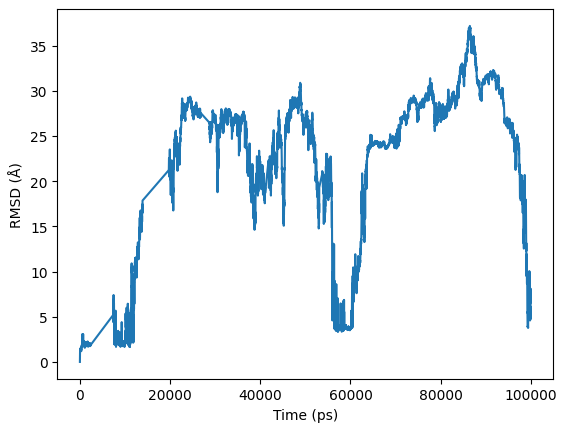

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import matplotlib.pyplot as plt

# load the trajectory and topology files
u = mda.Universe('6wzu_solv_ions.pdb', 'md_1_all.xtc')

# calculate the RMSD
ref = u.select_atoms('protein')
R = rms.RMSD(u, ref, select='backbone', groupselections=['protein'])
R.run()

# plot the RMSD
plt.plot(R.rmsd[:,1], R.rmsd[:,2])
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (Å)')

# save the plot as a PNG file
plt.savefig('rmsd_plot.png', dpi=300)

# show the plot
plt.show()


/usr/local/lib/python3.9/dist-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


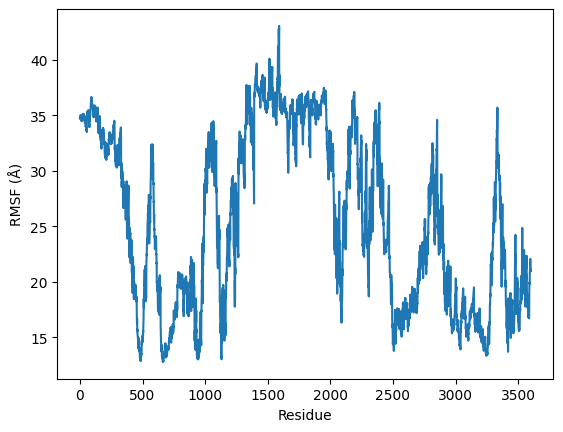

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import numpy as np
import matplotlib.pyplot as plt

# load the trajectory and topology files
u = mda.Universe('6wzu_solv_ions.pdb', 'md_1_all.xtc')

# select protein atoms for analysis
protein = u.select_atoms('protein')

# calculate the RMSF
R = rms.RMSF(protein).run()
rmsf_analysis = R.rmsf

# plot the RMSF
plt.plot(rmsf_analysis)
plt.xlabel('Residue')
plt.ylabel('RMSF (Å)')

# save the plot as a PNG file
plt.savefig('rmsf_plot.png', dpi=300)

# show the plot
plt.show()


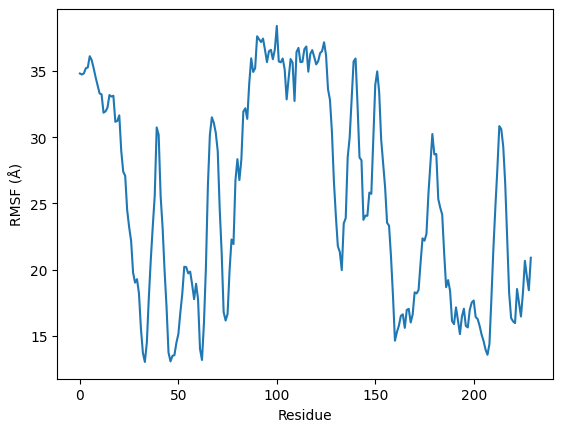

In [ ]:
# rmsf ;  c-alpha
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import numpy as np
import matplotlib.pyplot as plt

# load the trajectory and topology files
u = mda.Universe('6wzu_solv_ions.pdb', 'md_1_all.xtc')

# select C-alpha atoms for analysis
calpha = u.select_atoms('protein and name CA')

# calculate the RMSF
R = rms.RMSF(calpha, C_alpha=True).run()
rmsf_analysis = R.rmsf

# plot the RMSF
plt.plot(rmsf_analysis)
plt.xlabel('Residue')
plt.ylabel('RMSF (Å)')

# save the plot as a PNG file
plt.savefig('rmsf_ca_plot.png', dpi=300)

# show the plot
plt.show()


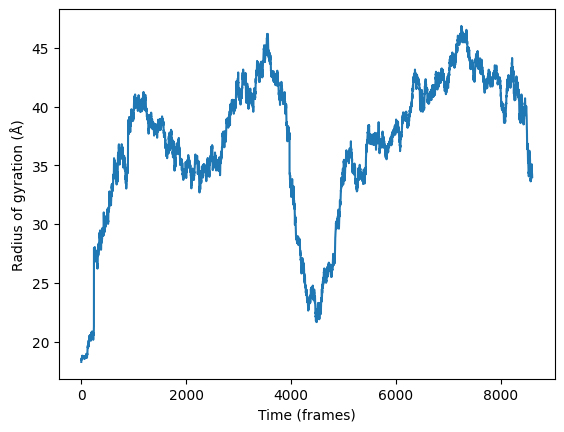

In [ ]:
#Rg
# load the trajectory and topology files
u = mda.Universe('6wzu_solv_ions.pdb', 'md_1_all.xtc')

# select protein atoms for analysis
protein = u.select_atoms('protein')

# calculate the radius of gyration
com = np.array([protein.center_of_mass()])
Rg_list = []
for ts in u.trajectory:
    Rg = np.sqrt(np.sum((protein.positions - com)**2)/len(protein))
    Rg_list.append(Rg)

# plot the radius of gyration
plt.plot(np.arange(len(Rg_list)), Rg_list)
plt.xlabel('Time (frames)')
plt.ylabel('Radius of gyration (Å)')


# save the plot as a PNG file
plt.savefig('rg_plot.png', dpi=300)

# show the plot
plt.show()


## Clustering, Cart. PCA, Pairw. PCA, SASA

In [ ]:
import MDAnalysis as mda
u = mda.Universe('6wzu_solv_ions.pdb', 'md_1_all.xtc')

In [ ]:
import MDAnalysis as mda
u = mda.Universe('6wzu_solv_ions.pdb', 'md_1_all.xtc')
ag = u.select_atoms("name CA")
ag.write("c-alpha.pdb")

/usr/local/lib/python3.9/dist-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/usr/local/lib/python3.9/dist-packages/MDAnalysis/coordinates/PDB.py:1176: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


In [ ]:
# Pass in the frames keyword to write out trajectories.
ag.write('c-alpha_all.xtc', frames='all')

In [ ]:
# Slice or index the trajectory to choose which frames to write:
ag.write('c-alpha_skip2.trr', frames=u.trajectory[::2])
ag.write('c-alpha_some.dcd', frames=u.trajectory[[0,2,3]])

In [ ]:
# Alternatively, iterate over the trajectory frame-by-frame with Writer(). This requires you to pass in the number of atoms to write.
with mda.Writer('c-alpha.xyz', ag.n_atoms) as w:
    for ts in u.trajectory:
        w.write(ag)

In [ ]:
pwd

'/content/gdrive/MyDrive/works/research/psmb8/psmb8-100/3unf-g210v-100/analysis-apr06'

In [ ]:
import mdtraj as md
t = md.load('c-alpha_all.xtc', top='c-alpha.pdb')
print(t)

<mdtraj.Trajectory with 8602 frames, 230 atoms, 230 residues, and unitcells>


In [ ]:
# lets take a look at the first ten frames
print(t[1:10])

<mdtraj.Trajectory with 9 frames, 230 atoms, 230 residues, and unitcells>


In [ ]:
# lets take a look at the last ten frames
print(t[-10:])

<mdtraj.Trajectory with 10 frames, 230 atoms, 230 residues, and unitcells>


In [ ]:
>>> # or maybe the last frame?
>>> print(t[-1])

<mdtraj.Trajectory with 1 frames, 230 atoms, 230 residues, and unitcells>


In [ ]:
print(t.xyz.shape)

(8602, 230, 3)


In [ ]:
# the simulation time (in picoseconds) of the first 10 frames
print(t.time[0:10])

[ 0. 10. 20. 30. 40. 50. 60. 70. 80. 90.]


In [ ]:
# the simulation time (in picoseconds) of th last 10 frames
print(t.time[-10:])

[ 99910.  99920.  99930.  99940.  99950.  99960.  99970.  99980.  99990.
 100000.]


In [ ]:
# or the unitcell lengths in the last frame? (in nanometers of course)
t.unitcell_lengths[-1]

array([8.28308, 8.28308, 8.28308], dtype=float32)

In [ ]:
# the hdf5 format stores the topology inside the file for convenience
t[::2].save('halftraj.h5')

In [ ]:
# the hdf5 format stores the topology inside the file for convenience
t[-10:].save('last10f-traj.h5')

In [ ]:
# the hdf5 format stores the topology inside the file for convenience
t[-1000:].save('last1000f-traj.h5')

In [ ]:
# the hdf5 format stores the topology inside the file for convenience
t[-1000:].save('last100f-traj.h5')

In [ ]:
# the format will be parsed based on the extension, or you can call the
# format-specific save methods
t[0:10].save_dcd('first-ten-frames.dcd')

In [ ]:
# the format will be parsed based on the extension, or you can call the
# format-specific save methods
t[-10:].save_dcd('last-ten-frames.dcd')

In [ ]:
# the format will be parsed based on the extension, or you can call the
# format-specific save methods
t[-10:].save_dcd('last-ten-frames.dcd')

In [ ]:
atoms_to_keep = [a.index for a in t.topology.atoms if a.name == 'CA']
t.restrict_atoms(atoms_to_keep)  # this acts inplace on the trajectory
t.save('CA-only.h5')

### 02. Atom Selection

In [ ]:
from __future__ import print_function
import mdtraj as md

traj = md.load('CA-only.h5')
print(traj)

<mdtraj.Trajectory with 8602 frames, 230 atoms, 230 residues, and unitcells>


/usr/local/lib/python3.9/dist-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [ ]:
print('How many atoms?    %s' % traj.n_atoms)
print('How many residues? %s' % traj.n_residues)

How many atoms?    230
How many residues? 230


In [ ]:
frame_idx = 4 # zero indexed frame number
atom_idx = 9 # zero indexed atom index
print('Where is the fifth atom at the tenth frame?')
print('x: %s\ty: %s\tz: %s' % tuple(traj.xyz[frame_idx, atom_idx,:]))

Where is the fifth atom at the tenth frame?
x: 6.1870003	y: 5.287	z: 4.0360003


### Topology Object

In [ ]:
topology = traj.topology
print(topology)

<mdtraj.Topology with 1 chains, 230 residues, 230 atoms, 0 bonds>


In [ ]:
print('Fifth atom: %s' % topology.atom(4))
print('All atoms: %s' % [atom for atom in topology.atoms])

Fifth atom: TYR5-CA
All atoms: [ALA1-CA, LYS2-CA, ARG3-CA, GLY4-CA, TYR5-CA, SER6-CA, PHE7-CA, SER8-CA, LEU9-CA, THR10-CA, THR11-CA, PHE12-CA, SER13-CA, PRO14-CA, SER15-CA, GLY16-CA, LYS17-CA, LEU18-CA, VAL19-CA, GLN20-CA, ILE21-CA, GLU22-CA, TYR23-CA, ALA24-CA, LEU25-CA, ALA26-CA, ALA27-CA, VAL28-CA, ALA29-CA, GLY30-CA, GLY31-CA, ALA32-CA, PRO33-CA, SER34-CA, VAL35-CA, GLY36-CA, ILE37-CA, LYS38-CA, ALA39-CA, ALA40-CA, ASN41-CA, GLY42-CA, VAL43-CA, VAL44-CA, LEU45-CA, ALA46-CA, THR47-CA, GLU48-CA, LYS49-CA, LYS50-CA, GLN51-CA, LYS52-CA, SER53-CA, ILE54-CA, LEU55-CA, TYR56-CA, ASP57-CA, GLU58-CA, ARG59-CA, SER60-CA, VAL61-CA, HIS62-CA, LYS63-CA, VAL64-CA, GLU65-CA, PRO66-CA, ILE67-CA, THR68-CA, LYS69-CA, HIS70-CA, ILE71-CA, GLY72-CA, LEU73-CA, VAL74-CA, TYR75-CA, SER76-CA, GLY77-CA, MET78-CA, GLY79-CA, PRO80-CA, ASP81-CA, TYR82-CA, ARG83-CA, VAL84-CA, LEU85-CA, VAL86-CA, HIS87-CA, ARG88-CA, ALA89-CA, ARG90-CA, LYS91-CA, LEU92-CA, ALA93-CA, GLN94-CA, GLN95-CA, TYR96-CA, TYR97-CA, LEU98-C

In [ ]:
print('Second residue: %s' % traj.topology.residue(1))
print('All residues: %s' % [residue for residue in traj.topology.residues])

Second residue: LYS2
All residues: [ALA1, LYS2, ARG3, GLY4, TYR5, SER6, PHE7, SER8, LEU9, THR10, THR11, PHE12, SER13, PRO14, SER15, GLY16, LYS17, LEU18, VAL19, GLN20, ILE21, GLU22, TYR23, ALA24, LEU25, ALA26, ALA27, VAL28, ALA29, GLY30, GLY31, ALA32, PRO33, SER34, VAL35, GLY36, ILE37, LYS38, ALA39, ALA40, ASN41, GLY42, VAL43, VAL44, LEU45, ALA46, THR47, GLU48, LYS49, LYS50, GLN51, LYS52, SER53, ILE54, LEU55, TYR56, ASP57, GLU58, ARG59, SER60, VAL61, HIS62, LYS63, VAL64, GLU65, PRO66, ILE67, THR68, LYS69, HIS70, ILE71, GLY72, LEU73, VAL74, TYR75, SER76, GLY77, MET78, GLY79, PRO80, ASP81, TYR82, ARG83, VAL84, LEU85, VAL86, HIS87, ARG88, ALA89, ARG90, LYS91, LEU92, ALA93, GLN94, GLN95, TYR96, TYR97, LEU98, VAL99, TYR100, GLN101, GLU102, PRO103, ILE104, PRO105, THR106, ALA107, GLN108, LEU109, VAL110, GLN111, ARG112, VAL113, ALA114, SER115, VAL116, MET117, GLN118, GLU119, TYR120, THR121, GLN122, SER123, GLY124, GLY125, VAL126, ARG127, PRO128, PHE129, GLY130, VAL131, SER132, LEU133, LEU134, 

In [ ]:
atom = topology.atom(10)
print('''Hi! I am the %sth atom, and my name is %s. 
I am a %s atom with %s bonds. 
I am part of an %s residue.''' % ( atom.index, atom.name, atom.element.name, atom.n_bonds, atom.residue.name))

Hi! I am the 10th atom, and my name is CA. 
I am a carbon atom with 0 bonds. 
I am part of an THR residue.


### Put Everything Together

In [ ]:
print([atom.index for atom in topology.atoms if atom.element.symbol is 'C' and atom.is_sidechain])

[]


<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-65-d105203df8e0>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  print([atom.index for atom in topology.atoms if atom.element.symbol is 'C' and atom.is_sidechain])


In [ ]:
print([residue for residue in topology.chain(0).residues if residue.index % 2 == 0])

[ALA1, ARG3, TYR5, PHE7, LEU9, THR11, SER13, SER15, LYS17, VAL19, ILE21, TYR23, LEU25, ALA27, ALA29, GLY31, PRO33, VAL35, ILE37, ALA39, ASN41, VAL43, LEU45, THR47, LYS49, GLN51, SER53, LEU55, ASP57, ARG59, VAL61, LYS63, GLU65, ILE67, LYS69, ILE71, LEU73, TYR75, GLY77, GLY79, ASP81, ARG83, LEU85, HIS87, ALA89, LYS91, ALA93, GLN95, TYR97, VAL99, GLN101, PRO103, PRO105, ALA107, LEU109, GLN111, VAL113, SER115, MET117, GLU119, THR121, SER123, GLY125, ARG127, PHE129, VAL131, LEU133, ILE135, GLY137, ASN139, GLY141, PRO143, LEU145, GLN147, ASP149, SER151, ALA153, PHE155, TRP157, ALA159, ALA161, GLY163, ASN165, VAL167, GLY169, THR171, LEU173, LYS175, TYR177, GLU179, LEU181, LEU183, ASP185, ILE187, THR189, ILE191, THR193, LYS195, SER197, GLU199, GLN201, THR203, ASP205, ILE207, VAL209, ILE211, ASN213, ALA215, PHE217, ARG219, THR221, THR223, VAL225, ASP227, LEU229]


### Atom Selection Language

In [ ]:
print(topology.select('resid 1 to 2'))

[1 2]


In [ ]:
print(topology.select('name N and backbone'))

[]


In [ ]:
selection = topology.select_expression('name CA and resid 1 to 2')
print(selection)

[atom.index for atom in topology.atoms if ((atom.name == 'CA') and (1 <= atom.residue.index <= 2))
]


## 04. Clustering with md.rmsd() and scipy.cluster.hierarchy()


In [ ]:
# where-am-i?
! pwd

/content/gdrive/MyDrive/works/research/psmb8/psmb8-100/3unf-g210v-100/analysis-apr06


In [ ]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform

In [ ]:
traj = md.load('CA-only.h5')

In [ ]:
# compute pairwise rmsd between conformations
distances = np.empty((traj.n_frames, traj.n_frames))
for i in range(traj.n_frames):
    distances[i] = md.rmsd(traj, traj, i)
print('Max pairwise rmsd: %f nm' % np.max(distances))

Max pairwise rmsd: 4.936711 nm


In [ ]:
# Clustering only accepts reduced form. Squareform's checks are too stringent
# when calculating a massinve numer of frames initially it was 1e-6; changed to 1e6 and the plot generated.
assert np.all(distances - distances.T < 1e6)
reduced_distances = squareform(distances, checks=False)

In [ ]:
linkage = scipy.cluster.hierarchy.linkage(reduced_distances, method='average')

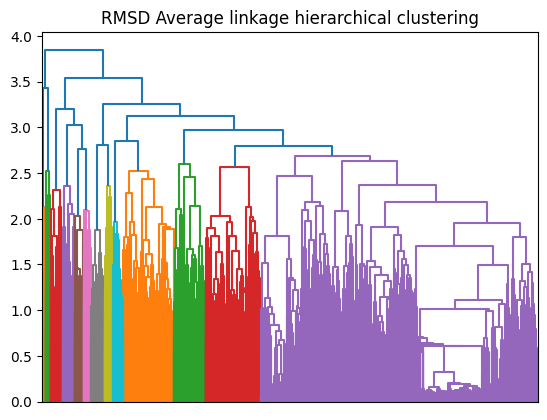

In [ ]:
plt.title('RMSD Average linkage hierarchical clustering')
_ = scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')

# save the plot as a PNG file
plt.savefig('RMSD Average linkage hierarchical clustering.png', dpi=300)

# show the plot
plt.show()

## 10. Principal components analysis (PCA) with scikit-learn

In [ ]:
%matplotlib inline
from __future__ import print_function
import mdtraj as md
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
traj = md.load('CA-only.h5')
traj

/usr/local/lib/python3.9/dist-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


<mdtraj.Trajectory with 8602 frames, 230 atoms, 230 residues, and unitcells at 0x7faa39b56fa0>

In [ ]:
pca1 = PCA(n_components=2)
traj.superpose(traj, 0)

<mdtraj.Trajectory with 8602 frames, 230 atoms, 230 residues, and unitcells at 0x7faa39b56fa0>

In [ ]:
reduced_cartesian = pca1.fit_transform(traj.xyz.reshape(traj.n_frames, traj.n_atoms * 3))
print(reduced_cartesian.shape)

(8602, 2)


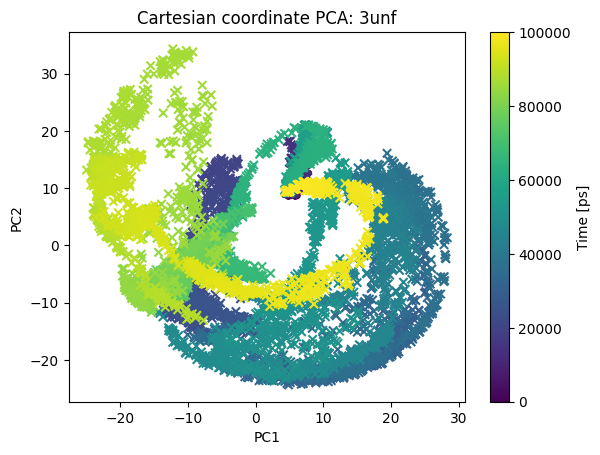

In [ ]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=traj.time)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cartesian coordinate PCA: 3unf')
cbar = plt.colorbar()
cbar.set_label('Time [ps]')

# save the plot as a PNG file
plt.savefig('Cartesian coordinate PCA: 3unf.png', dpi=300)

# show the plot
plt.show()

In [ ]:
pca2 = PCA(n_components=2)

from itertools import combinations
# this python function gives you all unique pairs of elements from a list

atom_pairs = list(combinations(range(traj.n_atoms), 2))
pairwise_distances = md.geometry.compute_distances(traj, atom_pairs)
print(pairwise_distances.shape)
reduced_distances = pca2.fit_transform(pairwise_distances)

(8602, 26335)


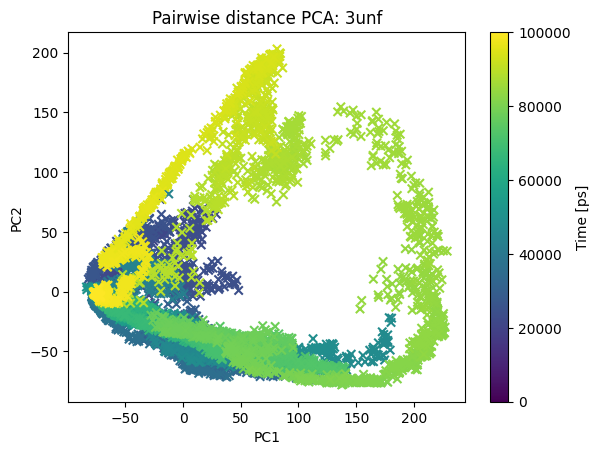

In [ ]:
plt.figure()
plt.scatter(reduced_distances[:, 0], reduced_distances[:,1], marker='x', c=traj.time)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Pairwise distance PCA: 3unf')
cbar = plt.colorbar()
cbar.set_label('Time [ps]')

# save the plot as a PNG file
plt.savefig('Pairwise distance PCA: 3unf.png', dpi=300)

# show the plot
plt.show()

## 13. Solvent Accesible Surface Area

In [ ]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import mdtraj as md

In [ ]:
help(md.shrake_rupley)

In [ ]:
trajectory = md.load('CA-only.h5')
sasa = md.shrake_rupley(trajectory)

print(trajectory)
print('sasa data shape', sasa.shape)

/usr/local/lib/python3.9/dist-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


<mdtraj.Trajectory with 8602 frames, 230 atoms, 230 residues, and unitcells>
sasa data shape (8602, 230)


In [ ]:
total_sasa = sasa.sum(axis=1)
print(total_sasa.shape)

(8602,)


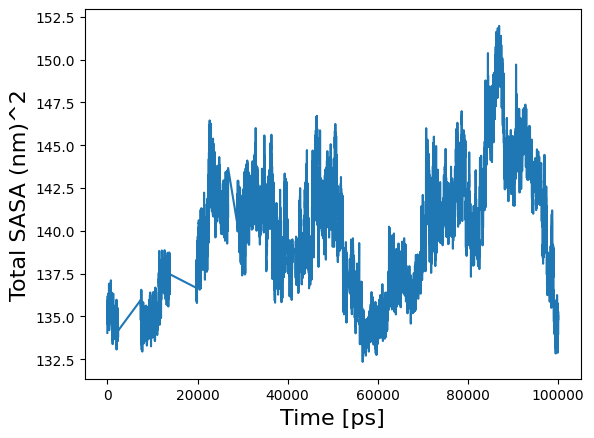

In [ ]:
from matplotlib.pylab import *

plot(trajectory.time, total_sasa)
xlabel('Time [ps]', size=16)
ylabel('Total SASA (nm)^2', size=16)


# save the plot as a PNG file
plt.savefig('Total_SASA.png', dpi=300)

# show the plot
plt.show()

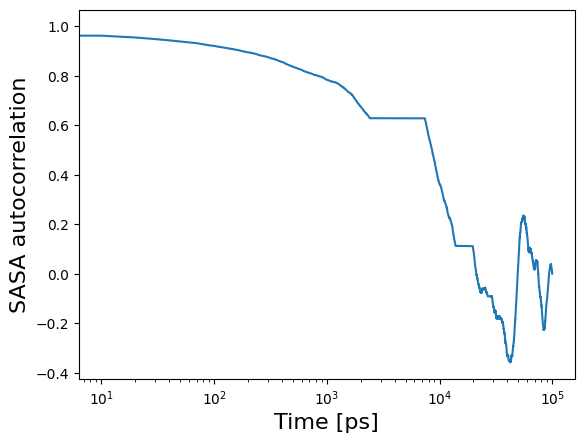

In [ ]:
def autocorr(x):
    "Compute an autocorrelation with numpy"
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size//2:]
    return result / result[0]

semilogx(trajectory.time, autocorr(total_sasa))
xlabel('Time [ps]', size=16)
ylabel('SASA autocorrelation', size=16)
show()

In [ ]:
!pwd

/content/gdrive/MyDrive/works/research/psmb8/3unf/3unf-wt+mut


# Part VII - Analysis of two Trajectories

## RMSD

/usr/local/lib/python3.9/dist-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


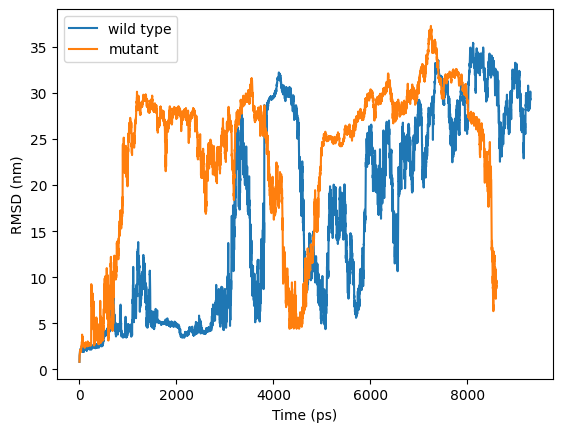

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import matplotlib.pyplot as plt

# Load the two trajectory and topology files
u1 = mda.Universe('3unf_wt_solv_ions.pdb', '3unf_wt_md_1_all.xtc')
u2 = mda.Universe('3unf_g210v_solv_ions.pdb', '3unf_g210v_md_1_all.xtc')

# Define the reference structure for each trajectory
ref1 = mda.Universe('3unf_wt_solv_ions.pdb')
ref2 = mda.Universe('3unf_g210v_solv_ions.pdb')

# Calculate RMSD for each trajectory
R1 = rms.RMSD(u1, ref1, select='protein')
R1.run()
rmsd1 = R1.rmsd[:, 2]  # get the RMSD values
time1 = R1.rmsd[:, 0]  # get the simulation time

R2 = rms.RMSD(u2, ref2, select='protein')
R2.run()
rmsd2 = R2.rmsd[:, 2]  # get the RMSD values
time2 = R2.rmsd[:, 0]  # get the simulation time

# Plot RMSD values of both trajectories on the same plot
fig, ax = plt.subplots()
ax.plot(time1, rmsd1, label='wild type')
ax.plot(time2, rmsd2, label='mutant')
ax.set_xlabel('Time (ps)')
ax.set_ylabel('RMSD (nm)')
ax.legend()

# Save the plot as a high-resolution PNG image
fig.savefig('rmsd.png', dpi=300)

plt.show()


## RMSF C-ALPHA

/usr/local/lib/python3.9/dist-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


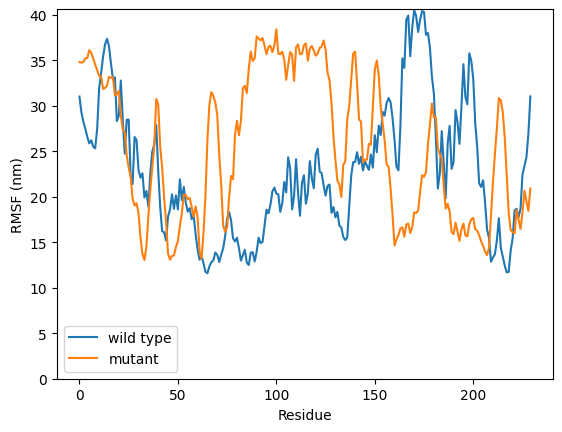

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms
from MDAnalysis.analysis.rms import RMSF
import matplotlib.pyplot as plt

# Load the trajectory and topology files for both systems
u1 = mda.Universe('3unf_wt_solv_ions.pdb', '3unf_wt_md_1_all.xtc')
u2 = mda.Universe('3unf_g210v_solv_ions.pdb', '3unf_g210v_md_1_all.xtc')

# Select the C-alpha atoms
calpha1 = u1.select_atoms('protein and name CA')
calpha2 = u2.select_atoms('protein and name CA')

# Align the protein to the reference structure
ref1 = mda.Universe('3unf_wt_solv_ions.pdb')
ref2 = mda.Universe('3unf_g210v_solv_ions.pdb')
R1 = rms.RMSD(u1, ref1, select='protein and name CA', center=True, superposition=True)
R1.run()
R2 = rms.RMSD(u2, ref2, select='protein and name CA', center=True, superposition=True)
R2.run()

# Calculate RMSF for each trajectory
RMSF1 = RMSF(calpha1).run()
RMSF2 = RMSF(calpha2).run()

# Plot RMSF values of both trajectories on the same plot
fig, ax = plt.subplots()
ax.plot(RMSF1.rmsf, label='wild type')
ax.plot(RMSF2.rmsf, label='mutant')
ax.set_xlabel('Residue')
ax.set_ylabel('RMSF (nm)')
ax.legend()

# Set the y-axis limits based on the range of your RMSF values
ymin = 0
ymax = max(RMSF1.rmsf.max(), RMSF2.rmsf.max()) + 0.1
ax.set_ylim(ymin, ymax)

# Save the plot as a high-resolution PNG image
fig.savefig('rmsf.png', dpi=300)

plt.show()


## Rg

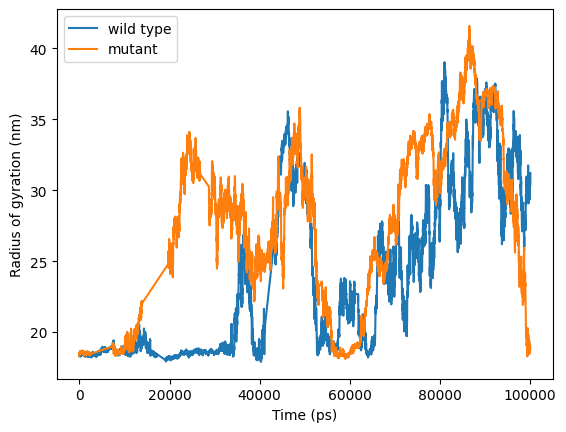

In [ ]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

# Load the trajectory and topology files for both systems
u1 = mda.Universe('3unf_wt_solv_ions.pdb', '3unf_wt_md_1_all.xtc')
u2 = mda.Universe('3unf_g210v_solv_ions.pdb', '3unf_g210v_md_1_all.xtc')

# Select only protein atoms
protein_sel1 = u1.select_atoms('protein')
protein_sel2 = u2.select_atoms('protein')

# Initialize arrays to store Rg values and time
Rg1 = np.zeros(len(u1.trajectory))
Rg2 = np.zeros(len(u2.trajectory))
time1 = np.zeros(len(u1.trajectory))
time2 = np.zeros(len(u2.trajectory))

# Loop over all frames in trajectory and calculate Rg
for ts in u1.trajectory:
    Rg1[ts.frame] = protein_sel1.radius_of_gyration()
    time1[ts.frame] = u1.trajectory.time

for ts in u2.trajectory:
    Rg2[ts.frame] = protein_sel2.radius_of_gyration()
    time2[ts.frame] = u2.trajectory.time

# Plot Rg values of both systems on the same plot
fig, ax = plt.subplots()
ax.plot(time1, Rg1, label='wild type')
ax.plot(time2, Rg2, label='mutant')
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Radius of gyration (nm)')
ax.legend()

# Save the plot as a high-resolution PNG image
fig.savefig('rg.png', dpi=300)

plt.show()


## SASA

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis.sasa import SASA

# Load the trajectory files
u_wt = mda.Universe("3unf_wt_solv_ions.pdb", "3unf_wt_md_1_all.xtc")
u_mut = mda.Universe("3unf_g210v_solv_ions.pdb", "3unf_g210v_md_1_all.xtc")

# Select the protein atoms
protein_selection = "protein"

# Calculate SASA for the wild-type trajectory
sasa_wt = SASA(u_wt, select=protein_selection)
sasa_wt.run()

# Calculate SASA for the mutant trajectory
sasa_mut = SASA(u_mut, select=protein_selection)
sasa_mut.run()

# Print the SASA values
print("Wild-type SASA:", sasa_wt.sasa)
print("Mutant SASA:", sasa_mut.sasa)
